In [3]:
def iTunesSearch(artist):
    import requests; import json 
    res=requests.get('https://itunes.apple.com/search',params={'media':'music','term':artist})
    data=json.loads(res.text)
    lis_songs=[]
    for items in data['results']:
        if items['trackName'] not in lis_songs: 
            #in case the song does not have all of the information, it will only get the album cover, track name, and the link to the preview 
            try: lis_songs.append((items['trackName'],items['previewUrl'],items['artworkUrl60'],items['releaseDate'],items['trackPrice'],items['trackViewUrl']))
            except:lis_songs.append((items['trackName'],items['previewUrl'],items['artworkUrl60'],items['trackViewUrl']))
    return lis_songs
def getArtist():
    lst_sngs=[]
    while True:
        user_in=input('Enter a search term (or "done" to stop): ')
        if user_in=='done':
            print(str(len(lst_sngs))+ ' song total')
            break 
        songs=iTunesSearch(user_in)
        for items in songs:
            lst_sngs.append(items)
    return lst_sngs
def blanked(word):
    for chars in word: 
        if chars.isalnum()==True: 
            word=word.replace(chars,'_')
    return word 
#defines a function to communicate with the taste api and get a brief bio of the artist
def artistInfo(artist):
    import requests; import json
    res=requests.get("https://tastedive.com/api/similar",params={'q':artist,'limit':5,"type":'','verbose':1})
    artist_info=json.loads(res.text)
    for items in artist_info['Similar']['Info']: 
        bio=items['wTeaser']
    return bio
#defines a function to communicate with the taste api to give the user 5 artist recommendations based on the singer they chose 
def artistRec(artist):
    import requests; import json
    lis_artists=[]
    res=requests.get("https://tastedive.com/api/similar",params={'q':artist,'limit':5,"type":''})
    artist_rec=json.loads(res.text)
    for items in artist_rec['Similar']['Results']:
        lis_artists.append(items['Name'])
    return lis_artists
#defines a function that communicates with the heroku app api in order to pull up any image related to the search parameters. 
def getImage(artist): 
    from PIL import Image; import requests; import json 
    lis_photos=[]
    res=requests.get("https://imsea.herokuapp.com/api/1?",params={'q':artist})
    data=json.loads(res.text)
    for items in data['results']: 
        lis_photos.append(items)
    photo=lis_photos[0]
    return Image.open(requests.get(photo,stream=True).raw)
#uses the previous to functions to ask for user input again if they want more information related to the artist of their choosing
def getArtistInfo(): 
    import requests; import json 
    user_in=input("Please re-enter ONE artist or choose a new one: ")
    rec=artistRec(user_in)
    info=artistInfo(user_in)
    getImage(user_in)
    #clears output above so after two seconds so it will only display the information generated from the API 
    time.sleep(2)
    clear_output()
    print(f'==Artist Info==')
    print(info)
    print('')
    print('==Artist recommendations==')
    for items in rec: 
        print(f'artist: {items}')

In [4]:
#updated code 
from IPython.display import display, Audio, clear_output,Image
import random
import time 
import mimetypes
mimetypes.init()
mimetypes.add_type('audio/mp4', '.m4a')

def playGame():
    from IPython.display import display, Audio, clear_output, Image;import time
    import random
    num=1
    wrong=0 #variables to calculate percentage of correct answers 
    right=0
    songs_like=[] #list which will be populated with tuples with information about the songs the user liked 
    game_state=True
    lst_songs=getArtist()
    print('_____ _____')#formatting
    game_play=True
    while (game_play==True):
        if game_state==True: 
            #display(Image(random_tuple[2])): displays album cover of the song 
            random_tuple=random.choice(lst_songs);display(Image(random_tuple[2]));display(Audio(random_tuple[1],autoplay=True));display(blanked(random_tuple[0]));display(f'== Round {num} ==')
        guesses=input("guess the song or 'skip' or 'exit': ")
        if guesses.lower()==random_tuple[0].lower():
            liked_song=input("Did you like the song? (enter 'y' for yes or 'n' for no ): ")
            display("You got it!")
            right+=1;num+=1
            #right: keeps track of the number of songs the user gets correct 
            time.sleep(3)
            clear_output()
            game_state=False
            #asks the user if they liked the song they listened to, enter 'y' for yes, anything else will be taken as a no 
            if liked_song=='y':
                try: songs_like.append((random_tuple[0],random_tuple[4],random_tuple[5]))
                except: songs_like.append((random_tuple[0]))
                game_state=True
            elif liked_song=='n':
                game_state=True
        elif guesses.lower() =='skip' :
            print(f'The song was {random_tuple[0]}')
            liked_song=input("Did you like the song? (enter 'y' for yes or 'n' for no ): ")
            num+=1
            time.sleep(3)
            clear_output()
            wrong+=1
            #counts time the user guessed incorrectly 
            game_state=False
            #if the user likes the song, it will append the name, price, and link to the list 
            if liked_song=='y':
                try: songs_like.append((random_tuple[0],random_tuple[4],random_tuple[5]))
                except: songs_like.append((random_tuple[0]))
                game_state=True
            else:
                game_state=True        
        elif guesses.lower()=='exit':
            #this will ask the user after each song plays if they liked the song
            liked_song=input("Did you like the song? (enter 'y' for yes or 'n' for no ): ")
            if liked_song=='y':
                #try and except in case the song does not have the price and link listed from the iTunes api
                try: songs_like.append((random_tuple[0],random_tuple[4],random_tuple[5]))
                except: songs_like.append((random_tuple[0]))
            #calculates the percentage of correct answers and displays them to the user
            #Try and except to prevent division by 0 if the user exits immediately 
            try: percent_right=int((right/(wrong+right))*100)
            except: percent_right=0
            display(f'the song was {random_tuple[0]} you guessed correctly {percent_right}% of the time')
            time.sleep(3)
            clear_output()
            getImage('GAME OVER')
            print('     ====== GAME OVER ======')#formatting
            print('')
            #asks the user if they want additional artist information, if they enter anything other than 'y' the program will not give more info and just give the song list
            #if the user enters 'y' they will be prompted to re-enter the artist they chose or choose a new one
            user_in=input("Do you want more artist information? (enter 'y' for yes or 'n' for no): ")
            if user_in=='y':
                getArtistInfo()
                #this will generate a list of recommended artists and a short artist summary if the user enters 'y'
            song_num=1
            #keeps track of song in list starting index at one 
            game_play=False
            print('')#formatting
            print('==List of liked songs==')#formatting

            for items in songs_like: 
                song_num+=1
                #try: if the user said they liked the song, the program will display the song with the price as well as a link on iTunes so they can listen to new music 
                #except: if the track does not have a price or link to the website, it will only display the song name 
                try: print(f'song #{song_num}: {items[0]} || price: {items[1]}$ || link: {items[2]}') 
                except: print(f'song #{song_num}: {items[0]}')
            display(Image('https://umich.edu/skins/um2013/media/images/umich-logo.png'))
            print('     ====== GO BLUE ======')#formatting and Michigan logo from previous problem set 
        else:
            display(f"It's not {guesses}")
            wrong+=1
            game_state=False

==Artist Info==
Big Time Rush is an American pop music boy band formed in 2009. The group is composed of Kendall Schmidt, James Maslow, Logan Henderson, and Carlos Pena Jr. The group starred in Nickelodeon's television series, of the same name, Big Time Rush. The group initially signed with Nick Records in 2009 before transferring to Columbia Records. The show ran from November 28, 2009, to July 25, 2013. The pilot episode featured the group's first promotional single, "Big Time Rush". The group has released three studio albums: BTR in 2010, Elevate in 2011, and 24/Seven in 2013. The band went on indefinite hiatus in 2014 and is scheduled to begin performing again in December 2021.Nickelodeon signed Big Time Rush to a record deal in 2009 simultaneously with the television series, Big Time Rush. Then, Nickelodeon partnered with Columbia/Epic Label Group to produce the show and include the original music to the show. For the series, their debut single, "Big Time Rush", was released on No

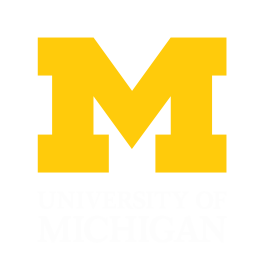

     ====== GO BLUE ======


In [5]:
playGame()